# Utils

In [1]:
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Tuple
from scipy.stats import linregress

In [2]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, ntime, _, nlon = ctos.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:,:,:nlats,i] = np.full((nmodel, ntime, nlats), np.nan) 
        
        jold = j
    
    return ctos

def get_rolling_timeseries(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "", gradient: bool = False) -> xr.DataArray:
    """Get the rolling timeseries of a dataset (optionally calculate gradient)

    Args:
        data (xr.DataArray): Input data.
        window (int, optional): Size of the rolling window. Defaults to 12*30.
        step (int, optional): Step size for each window. Defaults to 12.
        gradient (bool, optional): Calculate gradient if True, mean if False. Defaults to False.

    Returns:
        xr.DataArray: Resulting timeseries with same shape as input.
    """
    
    # Prepare output array with the same shape as input data
    new_time_size = 1 + (len(data.time) - window) // step
    rolling_shape = list(data.shape)
    rolling_shape[data.get_axis_num('time')] = new_time_size

    # Prepare output array with the adjusted shape
    rolling = np.full(rolling_shape, np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    # Loop to compute rolling statistics over time dimension
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        if gradient:
            rolling[:,j] = window*xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        else:
            rolling[:,j] = data.isel(time=slice(i, i+window)).mean(dim="time").values

    # Convert to xarray
    da = xr.DataArray(rolling, dims=data.dims, coords={**data.coords, 'time': np.arange(rolling.shape[1])})

    return da



# Load Data

In [3]:
cmip6_monthly_ssts = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP6_piControl.nc"))
cmip5_monthly_ssts = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP5_piControl.nc"))
# Replace all 0s with nans
cmip5_monthly_ssts["tos"] = cmip5_monthly_ssts["tos"].where(cmip5_monthly_ssts["tos"] != 0)
cmip5_monthly_ssts["tos"] = cmip5_monthly_ssts["tos"] - 273.15

cmip6_ept_ssts = fix_coords(get_triangle(cmip6_monthly_ssts.tos.copy(deep=True)).to_dataset()).spatial.average("tos").temporal.departures("tos", "month")["tos"]
cmip5_ept_ssts = fix_coords(get_triangle(cmip5_monthly_ssts.tos.copy(deep=True)).to_dataset()).spatial.average("tos").temporal.departures("tos", "month")["tos"]

cmip6_so_ssts = cmip6_monthly_ssts.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos").temporal.departures("tos", "month")["tos"]
cmip5_so_ssts = cmip5_monthly_ssts.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos").temporal.departures("tos", "month")["tos"] 

cmip_so_ssts = xr.concat([cmip6_so_ssts, cmip5_so_ssts], dim="model")
cmip_ept_ssts = xr.concat([cmip6_ept_ssts, cmip5_ept_ssts], dim="model")

For each latitude step of 2.5 degrees, longitude step is 7.5
For each latitude step of 2.5 degrees, longitude step is 7.5


In [15]:
import numpy as np
import scipy.signal as signal
import xarray as xr
import matplotlib.pyplot as plt

# Assuming cmip_so_ssts is your xarray DataArray with dimensions (model, time)

def apply_band_pass_butter(
    sst_data: np.ndarray,
    low_cutoff: int,
    high_cutoff: int
):
    sampling_rate = 1  # 1 sample per month

    # Convert cutoff frequencies from years to cycles per month
    low_cutoff_freq = 1 / low_cutoff  # Lower cutoff in cycles per month
    high_cutoff_freq = 1 / high_cutoff  # Upper cutoff in cycles per month
    filter_order = 2  # Order of the Butterworth filter

    # Design the Butterworth band-pass filter
    b, a = signal.butter(N=filter_order, Wn=[low_cutoff_freq, high_cutoff_freq], btype='band', fs=sampling_rate)

    # Apply the filter
    filtered_sst = signal.filtfilt(b, a, sst_data)

    return filtered_sst

def apply_multiple_band_pass_filters_across_models(
    cmip_ssts: xr.DataArray, 
    start_year: int = 1, 
    end_year: int = 30,
    step_year: int = 2,
):
    # Prepare lists to store data for each model and band
    models = cmip_ssts.model.values
    times = cmip_ssts.time.values

    low_high_cuttoffs = [(high*12, high*12 + step_year*12) for high in range(start_year, end_year, step_year)]
    low_high_cuttoffs.insert(0, (6, 12)) # Add 6-12 month band
    low_high_cuttoffs.insert(0, (3, 6))  # Add 3-6 month band

    bands = [f'{high/12}-{low/12}_years' for (high, low) in low_high_cuttoffs]
    
    # Initialize an empty array to store the filtered results
    filtered_data = np.empty((len(models), len(times), len(bands)))
    
    # Loop over each model
    for model_idx, model_data in enumerate(cmip_ssts):
        model_data_np = model_data.to_numpy()
        
        # Loop over each band
        for band_idx, (high, low) in enumerate(low_high_cuttoffs):
            filtered_sst = apply_band_pass_butter(model_data_np, low_cutoff=low, high_cutoff=high)
            filtered_data[model_idx, :, band_idx] = filtered_sst
    
    # Create an xarray DataArray with the filtered data
    filtered_data_xr = xr.DataArray(
        filtered_data,
        coords={'model': models, 'time': times, 'band': bands},
        dims=['model', 'time', 'band']
    )

    # Convert the DataArray to a Dataset for easier access to each band as a variable
    filtered_ds = filtered_data_xr.to_dataset(dim='band')
    
    return filtered_ds

# Example usage with cmip_so_ssts DataArray
step_year = 3
filtered_so_ssts = apply_multiple_band_pass_filters_across_models(cmip_so_ssts, step_year=step_year)
filtered_ept_ssts = apply_multiple_band_pass_filters_across_models(cmip_ept_ssts, step_year=step_year)
filtered_so_ssts

<xarray.Dataset>
Dimensions:          (model: 94, time: 1800)
Coordinates:
  * model            (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'CNRM-CM5-2'
  * time             (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1999-12-01
Data variables:
    0.25-0.5_years   (model, time) float64 -2.858e-06 -0.0709 ... -0.0002277
    0.5-1.0_years    (model, time) float64 0.003282 0.1374 ... -0.1684 -0.001684
    1.0-4.0_years    (model, time) float64 0.02014 0.1018 ... -0.03687 0.04292
    4.0-7.0_years    (model, time) float64 -0.002224 0.01133 ... -0.01847
    7.0-10.0_years   (model, time) float64 -0.05765 -0.04935 ... 0.0002603
    10.0-13.0_years  (model, time) float64 -0.05367 -0.04651 ... -0.0003995
    13.0-16.0_years  (model, time) float64 -0.02249 -0.01795 ... -6.514e-05
    16.0-19.0_years  (model, time) float64 0.007339 0.01155 ... 3.633e-05
    19.0-22.0_years  (model, time) float64 -0.02252 -0.02001 ... 2.435e-06
    22.0-25.0_years  (model, time) float64 0.03276 0.03478 ... 1.863e-06
    25.0-28.0_years  (model, time) float64 0.03016 0.03096 ... -3.855e-06
    28.0-31.0_years  (model, time) float64 0.006779 0.007172 ... 3.703e-07

In [18]:
regs = {}
regs_std = {}
corrs = {}
corrs_std = {}

for i, band in enumerate(filtered_so_ssts):
    if i == 0: 
        band_center = 4.5/12 # center of 0-6 month band
    elif i == 1: 
        band_center = 8/12 # center of 6-12 month band
    else:
        band_center = float(band.split("-")[0]) + step_year/2

    so_band = filtered_so_ssts[band]
    ept_band = filtered_ept_ssts[band]
    regs[band_center] = xscore.linslope(so_band, ept_band, dim="time").mean("model").values
    regs_std[band_center] = xscore.linslope(so_band, ept_band, dim="time").std("model").values
    corrs[band_center] = xscore.pearson_r(so_band, ept_band, dim="time").mean("model").values
    corrs_std[band_center] = xscore.pearson_r(so_band, ept_band, dim="time").std("model").values


In [6]:
lags = np.arange(-12*5, 12*5)

def lagged_regression(ts_so_ssts, ts_ept_ssts, lags):
    reg_coeffs, rvalues, pvalues = [], [], []
    for lag in lags:
        rvalues.append(xscore.pearson_r(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))

    reg_coeffs = xr.Dataset({'reg': (['lags', 'model'], np.array(reg_coeffs))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    rvalues = xr.Dataset({'rvalues': (['lags', 'model'], np.array(rvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    pvalues = xr.Dataset({'pvalues': (['lags', 'model'], np.array(pvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues])
    return regs_dataset

lagged_so_ept_coupling = lagged_regression(filtered_so_ssts["7.0-10.0_years"], filtered_ept_ssts["7.0-10.0_years"], lags)
lagged_so_ept_coupling

<xarray.Dataset>
Dimensions:  (lags: 120, model: 94)
Coordinates:
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'FIO-ESM' 'CNRM-CM5-2'
  * lags     (lags) int64 -60 -59 -58 -57 -56 -55 -54 ... 53 54 55 56 57 58 59
Data variables:
    rvalues  (lags, model) float64 -0.4606 -0.4046 -0.4561 ... -0.6192 -0.6799
    reg      (lags, model) float64 -0.4476 -0.653 -0.5745 ... -1.068 -0.8616
    pvalues  (lags, model) float64 0.6953 0.7348 0.6985 ... 0.5532 0.5749 0.524

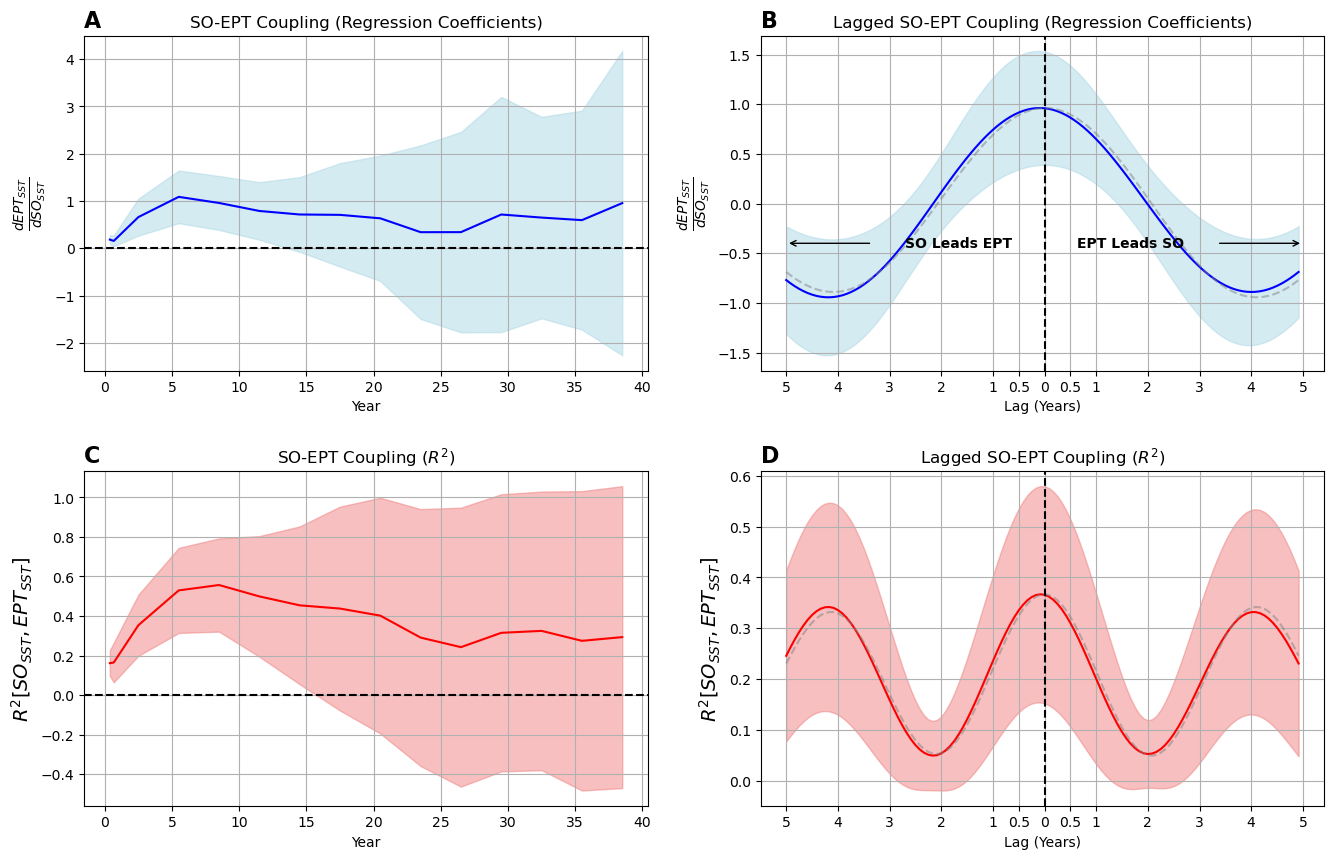

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Calculate the upper and lower bounds for shading
upper_bound_reg = np.array(list(regs.values())) + 1 * np.array(list(regs_std.values())) 
lower_bound_reg = np.array(list(regs.values())) - 1 * np.array(list(regs_std.values())) 

upper_bound_rvalues = np.array(list(corrs.values())) + 1 * np.array(list(corrs_std.values())) 
lower_bound_rvalues = np.array(list(corrs.values())) - 1 * np.array(list(corrs_std.values())) 


# Plot rvalues_so_ept_coupling
axs[0, 0].plot(regs.keys(), np.array(list(regs.values())), color='blue', label='Mean')
axs[0, 0].fill_between(regs.keys(), lower_bound_reg, upper_bound_reg, color='lightblue', alpha=0.5, label='2-sigma')
# axs[0, 0].set_xticks([6, 12, 24, 36, 48, *years[::-5]], labels=[.5, 1, 2, 3, 4, *np.arange(min_year, max_year+1)[::-5]])
# axs[0, 0].set_ylim(-.5, 1.25)
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
axs[0, 0].set_title(r'SO-EPT Coupling (Regression Coefficients)')
axs[0, 0].grid()
axs[0, 0].axhline(0, color='black', linestyle='--')

# Plot lag_so_ept_coupling
axs[0, 1].plot(lags, lagged_so_ept_coupling["reg"].mean(dim='model'), color='blue', label='Model Mean')
# reverse lagged_so_ept_coupling
reversed_lagged_so_ept_coupling = lagged_so_ept_coupling["reg"].mean(dim='model').values[::-1]
axs[0, 1].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")
axs[0, 1].fill_between(lags, lagged_so_ept_coupling["reg"].mean(dim='model') - lagged_so_ept_coupling["reg"].std(dim='model'), lagged_so_ept_coupling["reg"].mean(dim='model') + lagged_so_ept_coupling["reg"].std(dim='model'), color='lightblue', alpha=0.5, label='2-sigma')
axs[0, 1].set_xlabel('Lag (Years)')
axs[0, 1].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
axs[0, 1].set_title('Lagged SO-EPT Coupling (Regression Coefficients)')
axs[0, 1].set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
axs[0, 1].grid()

# Add text below x axis with arrows
axs[0, 1].text(-20, -0.4, "SO Leads EPT", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
axs[0, 1].annotate("", xy=(-60, -0.4), xytext=(-40, -0.4), arrowprops=dict(arrowstyle="->"))
axs[0, 1].text(20, -0.4, "EPT Leads SO", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
axs[0, 1].annotate("", xy=(60, -0.4), xytext=(40, -0.4), arrowprops=dict(arrowstyle="->"))

# Add vertical line at 0
axs[0, 1].axvline(0, color='black', linestyle='--')

# Plot rvalues_so_ept_coupling
axs[1, 0].plot(corrs.keys(), np.array(list(corrs.values())), color='red', label='Mean')
axs[1, 0].fill_between(corrs.keys(), lower_bound_rvalues, upper_bound_rvalues, color='lightcoral', alpha=0.5, label='2-sigma')
# axs[1, 0].set_xticks([6, 12, 24, 36, 48, *years[::-5]], labels=[.5, 1, 2, 3, 4, *np.arange(min_year, max_year+1)[::-5]])
# axs[1, 0].set_ylim(0, .75)
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
axs[1, 0].set_title(r'SO-EPT Coupling ($R^2$)')
axs[1, 0].grid()
axs[1, 0].axhline(0, color='black', linestyle='--')

# Plot lagged_so_ept_coupling
axs[1, 1].plot(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') , color='red', label='Mean')
axs[1, 1].fill_between(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') - (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') + (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), color='lightcoral', alpha=0.5, label='2-sigma')
reversed_lagged_so_ept_coupling = (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model').values[::-1]
axs[1, 1].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")
axs[1, 1].set_xlabel('Lag (Years)')
axs[1, 1].set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
axs[1, 1].set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
axs[1, 1].set_title('Lagged SO-EPT Coupling ($R^2$)')
axs[1, 1].grid()
axs[1, 1].axvline(0, color='black', linestyle='--')

axs[0, 0].set_title('A', loc="left", fontweight="bold", fontsize=16)
axs[0, 1].set_title('B', loc="left", fontweight="bold", fontsize=16)
axs[1, 0].set_title('C', loc="left", fontweight="bold", fontsize=16)
axs[1, 1].set_title('D', loc="left", fontweight="bold", fontsize=16)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3) #, wspace=0.3)

# Show the plot
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/band_filtered_so_ept_coupling_lagged_and_timescale.png", dpi=300)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/band_filtered_so_ept_coupling_lagged_and_timescale.pdf", dpi=300)

# Examine Lead Lag Relationship of Filtered Data

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/pyth

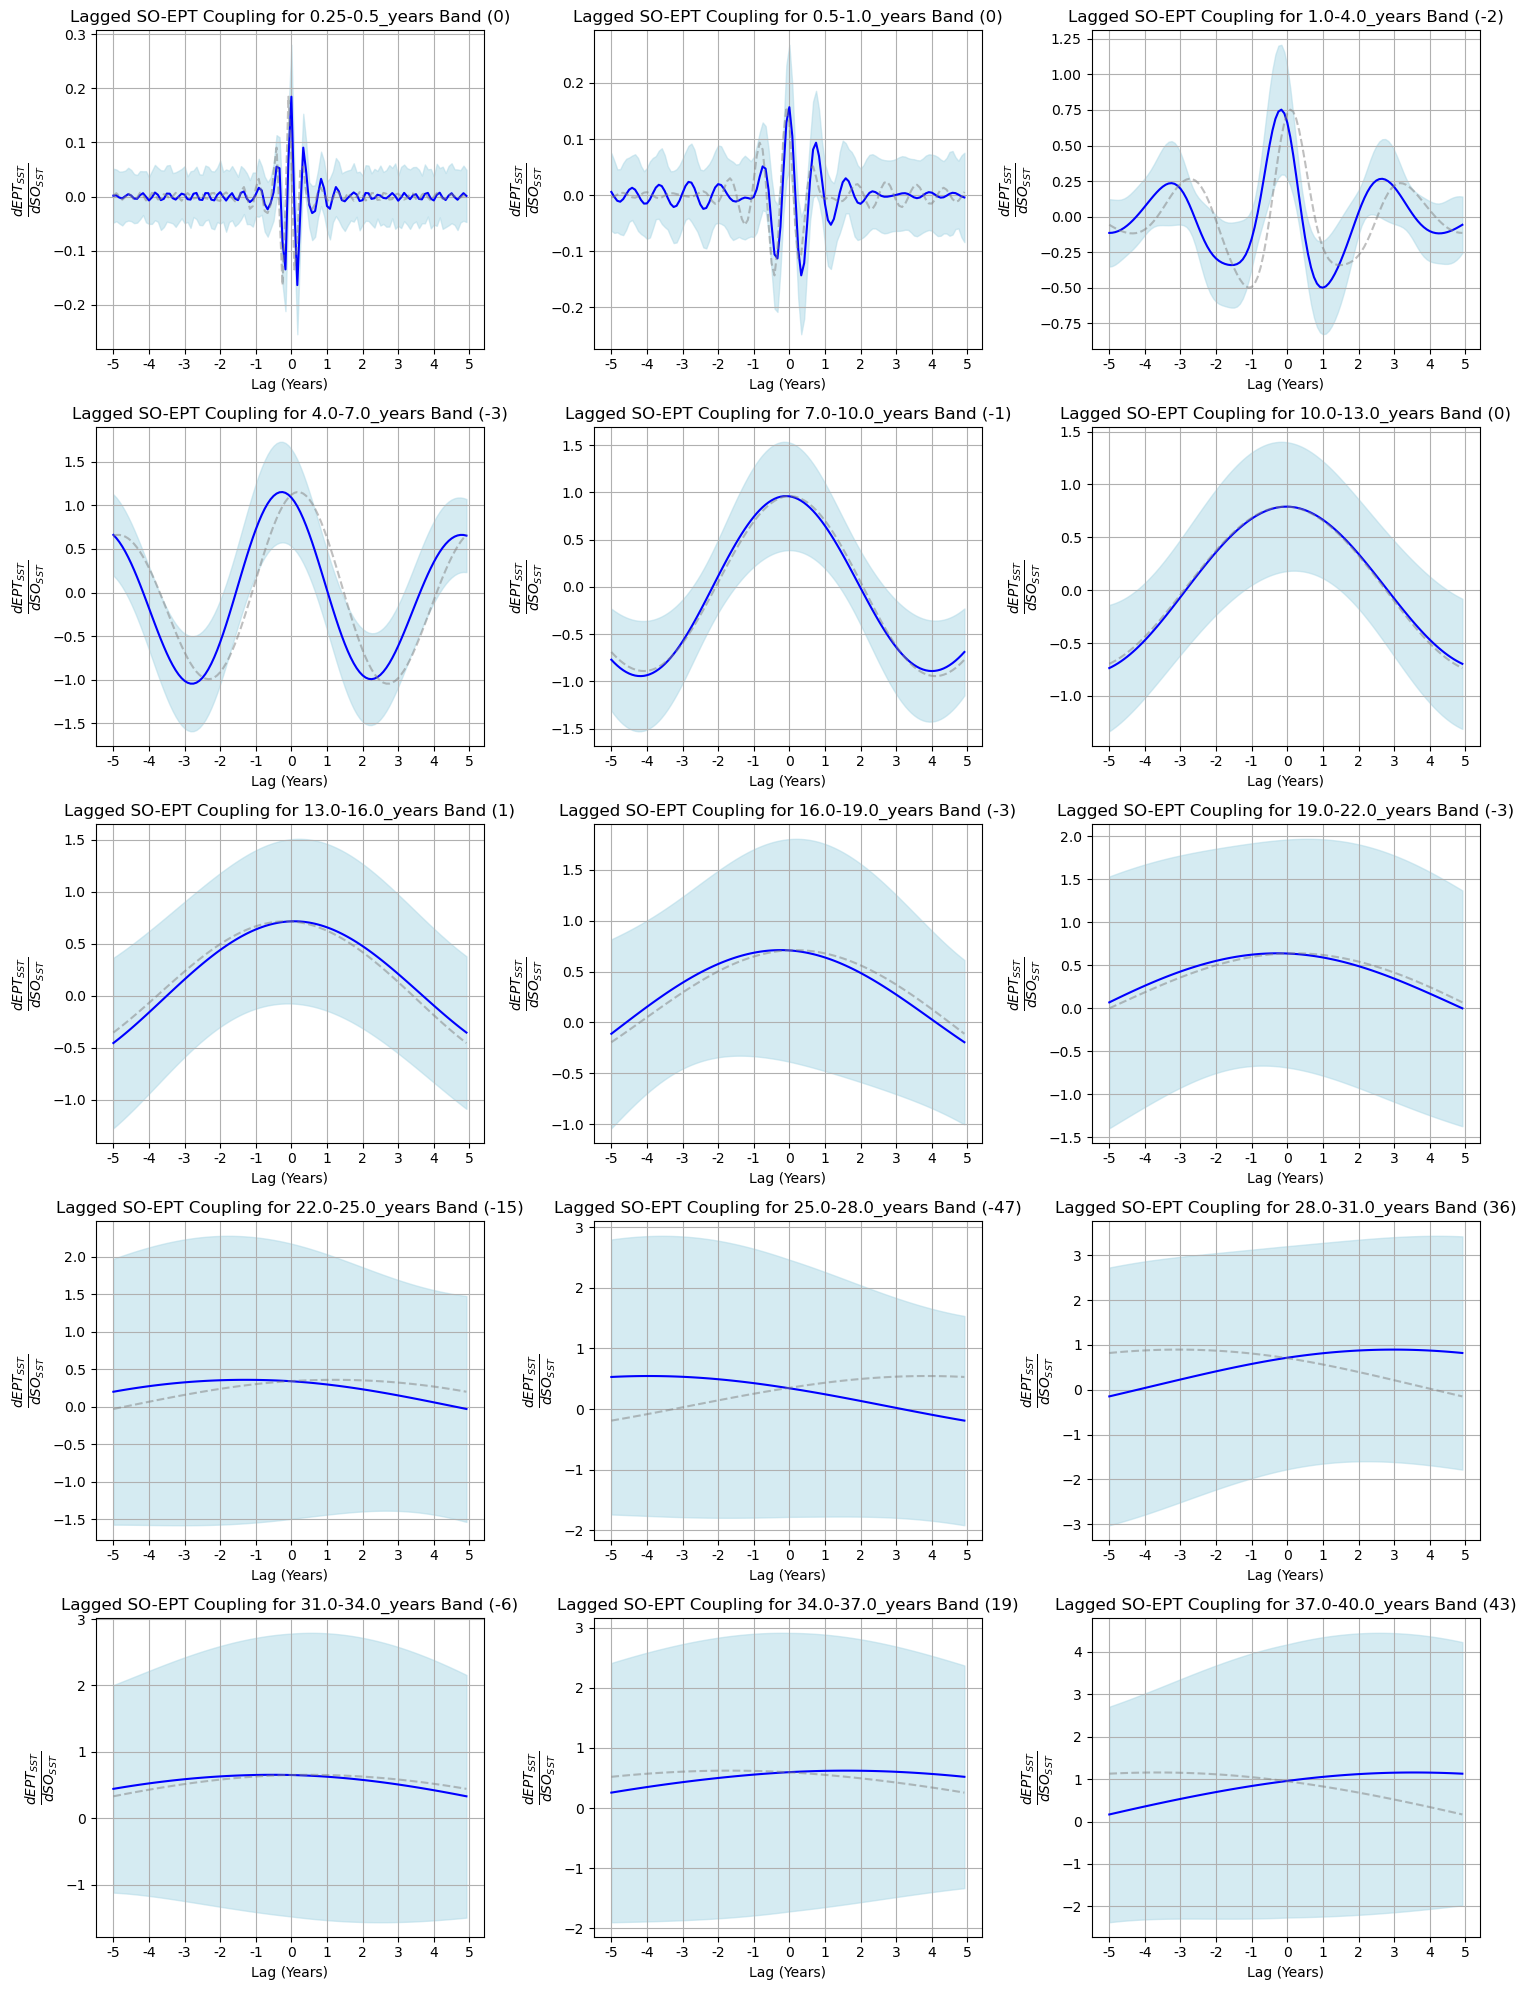

<Figure size 640x480 with 0 Axes>

In [7]:
# Assuming filtered_so_ssts and filtered_ept_ssts are xarray Datasets with dimensions `band`, `model`, and `time`.
# lags is an array of lag values, and lagged_regression is a function that calculates lagged regression coefficients.

# Set up the number of subplots based on the number of bands
n_bands = len(filtered_so_ssts)

# Determine subplot grid layout
n_cols = 3  # Number of columns
n_rows = (n_bands + n_cols - 1) // n_cols  # Number of rows to fit all bands

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.ravel()  # Flatten to make it easier to index

for i, band in enumerate(filtered_so_ssts):
    # Compute lagged SO-EPT coupling for the current band
    lagged_so_ept_coupling = lagged_regression(filtered_so_ssts[band], filtered_ept_ssts[band], lags)

    # Plot mean regression coefficient with shading for 2-sigma standard deviation
    axs[i].plot(lags, lagged_so_ept_coupling["reg"].mean(dim='model'), color='blue', label='Model Mean')
    axs[i].fill_between(
        lags,
        lagged_so_ept_coupling["reg"].mean(dim='model') - lagged_so_ept_coupling["reg"].std(dim='model'),
        lagged_so_ept_coupling["reg"].mean(dim='model') + lagged_so_ept_coupling["reg"].std(dim='model'),
        color='lightblue', alpha=0.5, label='2-sigma'
    )

    # Plot mirrored version for comparison
    reversed_lagged_so_ept_coupling = lagged_so_ept_coupling["reg"].mean(dim='model').values[::-1]
    axs[i].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")

    max_lag = lags[lagged_so_ept_coupling["reg"].mean(dim="model").argmax().values]

    # Set labels, title, and grid for the current subplot
    axs[i].set_xlabel('Lag (Years)')
    axs[i].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
    axs[i].set_title(f'Lagged SO-EPT Coupling for {band} Band ({max_lag})')
    axs[i].set_xticks(
        [-60, -48, -36, -24, -12, 0, 12, 24, 36, 48, 60],
        labels=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    )
    axs[i].grid()

# Adjust layout and add legend to the last plot
fig.tight_layout()
plt.show()

# Show the plot
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/band_filtered_so_ept_coupling_lagged_all.png", dpi=300)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/band_filtered_so_ept_coupling_lagged_all.pdf", dpi=300)

# Examine Lead Lag Relationship of Raw Anomaly Data

In [8]:
lags = np.arange(-12*5, 12*5)

def lagged_regression(ts_so_ssts, ts_ept_ssts, lags):
    reg_coeffs, rvalues, pvalues = [], [], []
    for lag in lags:
        rvalues.append(xscore.pearson_r(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))


    reg_coeffs = xr.Dataset({'reg': (['lags', 'model'], np.array(reg_coeffs))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    rvalues = xr.Dataset({'rvalues': (['lags', 'model'], np.array(rvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    pvalues = xr.Dataset({'pvalues': (['lags', 'model'], np.array(pvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues])
    return regs_dataset


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/pyth

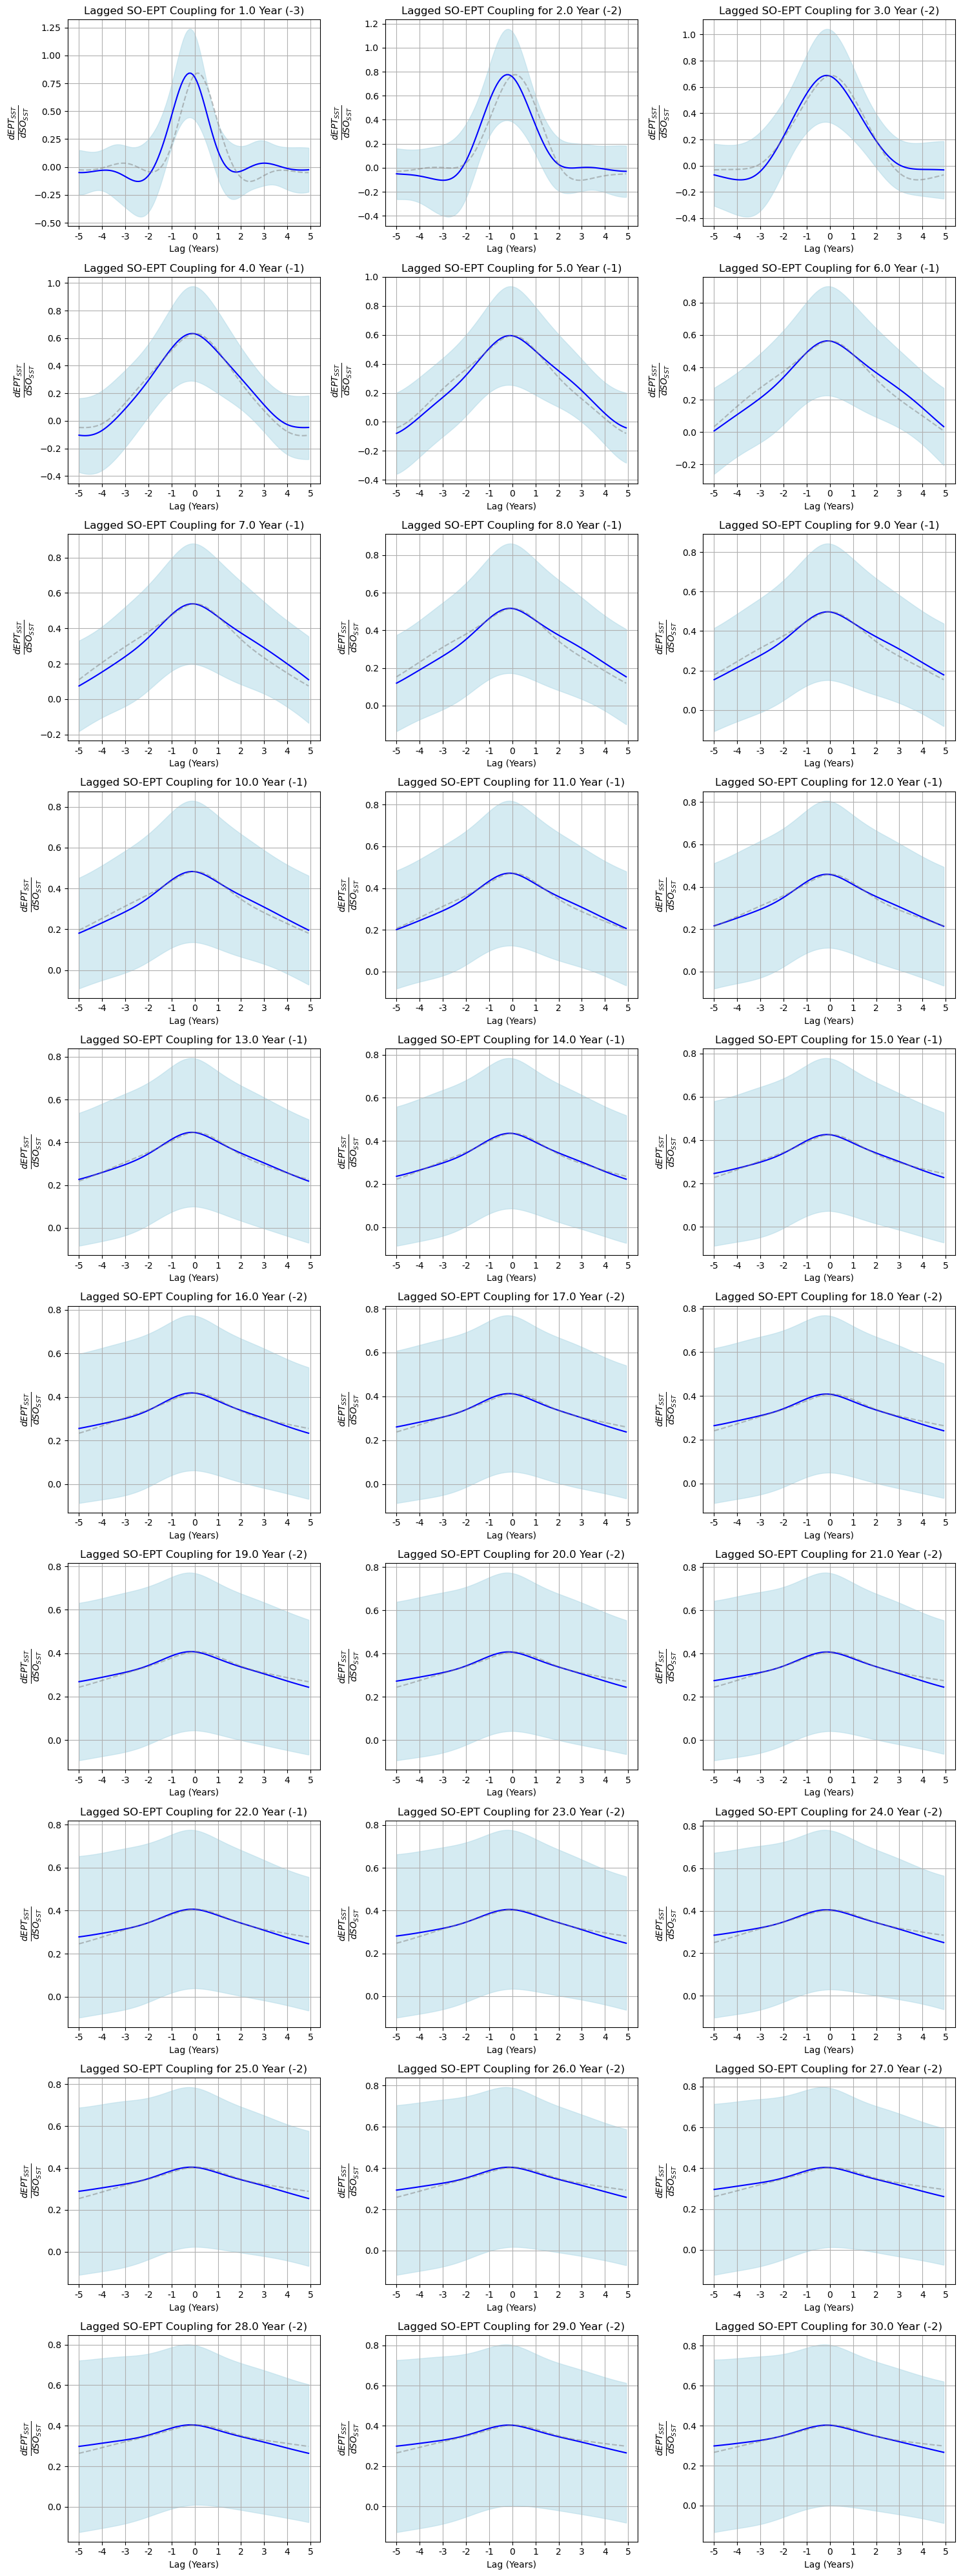

In [9]:
# Assuming filtered_so_ssts and filtered_ept_ssts are xarray Datasets with dimensions `band`, `model`, and `time`.
# lags is an array of lag values, and lagged_regression is a function that calculates lagged regression coefficients.
min_year, max_year = 1, 30
months = np.arange(1, 12)
years = np.arange(min_year*12, (max_year+1)*12, 12)

# Set up the number of subplots based on the number of bands
n_bands = len(years)

# Determine subplot grid layout
n_cols = 3  # Number of columns
n_rows = (n_bands + n_cols - 1) // n_cols  # Number of rows to fit all bands

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.ravel()  # Flatten to make it easier to index

for i, window in enumerate(years):
    # Compute lagged SO-EPT coupling for the current band
    # Explore Lagged-Regression Relationship
    ts_so_ssts = get_rolling_timeseries(cmip_so_ssts, window=window, step=1, gradient=False)
    ts_ept_ssts = get_rolling_timeseries(cmip_ept_ssts, window=window, step=1, gradient=False)

    lagged_so_ept_coupling = lagged_regression(ts_so_ssts, ts_ept_ssts, lags)

    # Plot mean regression coefficient with shading for 2-sigma standard deviation
    axs[i].plot(lags, lagged_so_ept_coupling["reg"].mean(dim='model'), color='blue', label='Model Mean')
    axs[i].fill_between(
        lags,
        lagged_so_ept_coupling["reg"].mean(dim='model') - lagged_so_ept_coupling["reg"].std(dim='model'),
        lagged_so_ept_coupling["reg"].mean(dim='model') + lagged_so_ept_coupling["reg"].std(dim='model'),
        color='lightblue', alpha=0.5, label='2-sigma'
    )

    # Plot mirrored version for comparison
    reversed_lagged_so_ept_coupling = lagged_so_ept_coupling["reg"].mean(dim='model').values[::-1]
    axs[i].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")

    max_lag = lags[lagged_so_ept_coupling["reg"].mean(dim="model").argmax().values]

    # Set labels, title, and grid for the current subplot
    axs[i].set_xlabel('Lag (Years)')
    axs[i].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
    axs[i].set_title(f'Lagged SO-EPT Coupling for {window/12} Year ({max_lag})')
    axs[i].set_xticks(
        [-60, -48, -36, -24, -12, 0, 12, 24, 36, 48, 60],
        labels=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    )
    axs[i].grid()

# Adjust layout and add legend to the last plot
fig.tight_layout()
# Show the plot
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/rolling_anoms_so_ept_coupling_lagged_all.png", dpi=300)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/rolling_anoms_so_ept_coupling_lagged_all.pdf", dpi=300)
plt.show()

# Create hybrid figure (B and D from anomaly analysis) (A and C from band filtered analysis)

In [16]:
window = 12
lags = np.arange(-12*5, 12*5)

ts_so_ssts = get_rolling_timeseries(cmip_so_ssts, window=window, step=1, gradient=False)
ts_ept_ssts = get_rolling_timeseries(cmip_ept_ssts, window=window, step=1, gradient=False)

lagged_so_ept_coupling = lagged_regression(ts_so_ssts, ts_ept_ssts, lags)

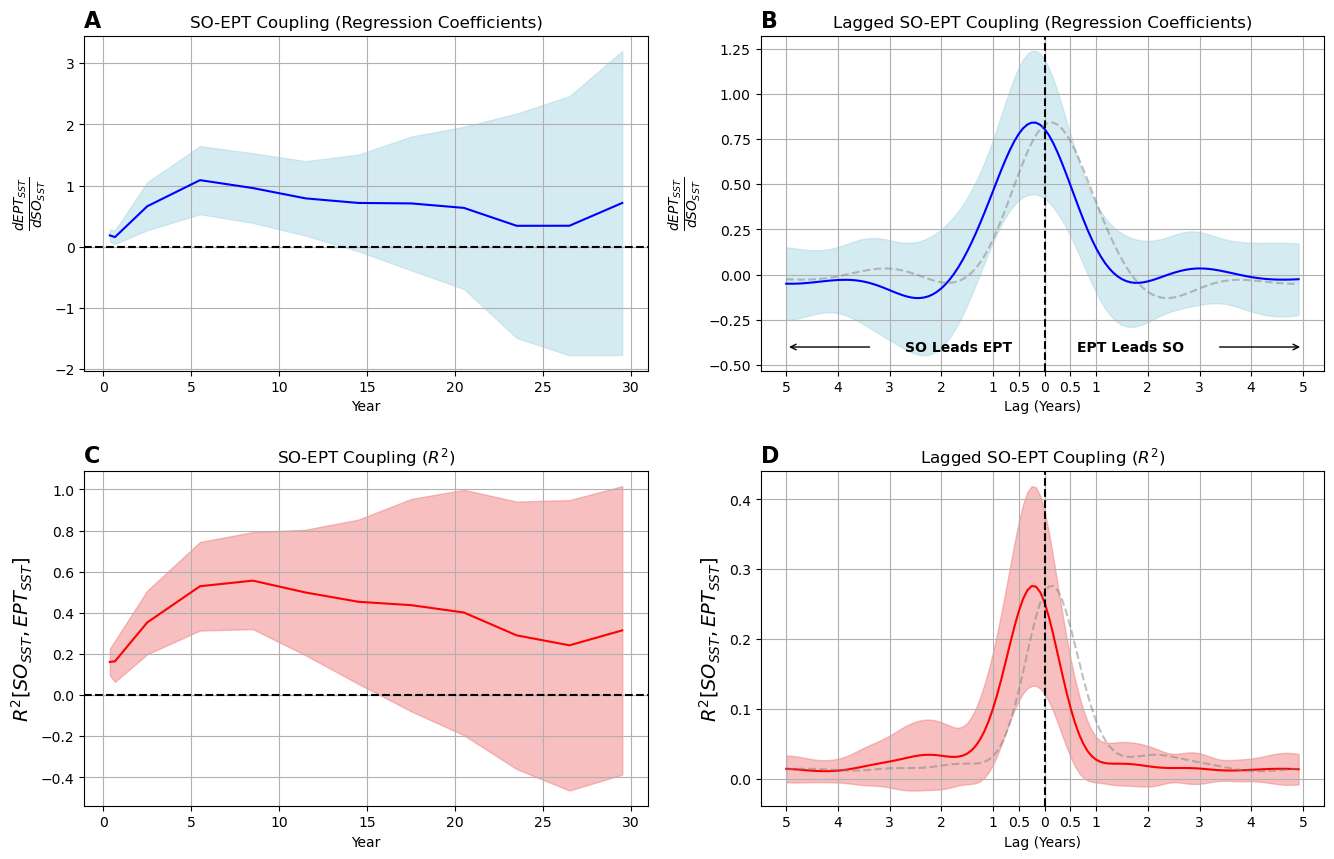

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Calculate the upper and lower bounds for shading
upper_bound_reg = np.array(list(regs.values())) + 1 * np.array(list(regs_std.values())) 
lower_bound_reg = np.array(list(regs.values())) - 1 * np.array(list(regs_std.values())) 

upper_bound_rvalues = np.array(list(corrs.values())) + 1 * np.array(list(corrs_std.values())) 
lower_bound_rvalues = np.array(list(corrs.values())) - 1 * np.array(list(corrs_std.values())) 


# Plot rvalues_so_ept_coupling
axs[0, 0].plot(regs.keys(), np.array(list(regs.values())), color='blue', label='Mean')
axs[0, 0].fill_between(regs.keys(), lower_bound_reg, upper_bound_reg, color='lightblue', alpha=0.5, label='2-sigma')
# axs[0, 0].set_xticks([6, 12, 24, 36, 48, *years[::-5]], labels=[.5, 1, 2, 3, 4, *np.arange(min_year, max_year+1)[::-5]])
# axs[0, 0].set_ylim(-.5, 1.25)
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
axs[0, 0].set_title(r'SO-EPT Coupling (Regression Coefficients)')
axs[0, 0].grid()
axs[0, 0].axhline(0, color='black', linestyle='--')

# Plot lag_so_ept_coupling
axs[0, 1].plot(lags, lagged_so_ept_coupling["reg"].mean(dim='model'), color='blue', label='Model Mean')
# reverse lagged_so_ept_coupling
reversed_lagged_so_ept_coupling = lagged_so_ept_coupling["reg"].mean(dim='model').values[::-1]
axs[0, 1].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")
axs[0, 1].fill_between(lags, lagged_so_ept_coupling["reg"].mean(dim='model') - lagged_so_ept_coupling["reg"].std(dim='model'), lagged_so_ept_coupling["reg"].mean(dim='model') + lagged_so_ept_coupling["reg"].std(dim='model'), color='lightblue', alpha=0.5, label='2-sigma')
axs[0, 1].set_xlabel('Lag (Years)')
axs[0, 1].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
axs[0, 1].set_title('Lagged SO-EPT Coupling (Regression Coefficients)')
axs[0, 1].set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
axs[0, 1].grid()

# Add text below x axis with arrows
axs[0, 1].text(-20, -0.4, "SO Leads EPT", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
axs[0, 1].annotate("", xy=(-60, -0.4), xytext=(-40, -0.4), arrowprops=dict(arrowstyle="->"))
axs[0, 1].text(20, -0.4, "EPT Leads SO", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
axs[0, 1].annotate("", xy=(60, -0.4), xytext=(40, -0.4), arrowprops=dict(arrowstyle="->"))

# Add vertical line at 0
axs[0, 1].axvline(0, color='black', linestyle='--')

# Plot rvalues_so_ept_coupling
axs[1, 0].plot(corrs.keys(), np.array(list(corrs.values())), color='red', label='Mean')
axs[1, 0].fill_between(corrs.keys(), lower_bound_rvalues, upper_bound_rvalues, color='lightcoral', alpha=0.5, label='2-sigma')
# axs[1, 0].set_xticks([6, 12, 24, 36, 48, *years[::-5]], labels=[.5, 1, 2, 3, 4, *np.arange(min_year, max_year+1)[::-5]])
# axs[1, 0].set_ylim(0, .75)
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
axs[1, 0].set_title(r'SO-EPT Coupling ($R^2$)')
axs[1, 0].grid()
axs[1, 0].axhline(0, color='black', linestyle='--')

# Plot lagged_so_ept_coupling
axs[1, 1].plot(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') , color='red', label='Mean')
axs[1, 1].fill_between(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') - (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') + (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), color='lightcoral', alpha=0.5, label='2-sigma')
reversed_lagged_so_ept_coupling = (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model').values[::-1]
axs[1, 1].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")
axs[1, 1].set_xlabel('Lag (Years)')
axs[1, 1].set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
axs[1, 1].set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
axs[1, 1].set_title('Lagged SO-EPT Coupling ($R^2$)')
axs[1, 1].grid()
axs[1, 1].axvline(0, color='black', linestyle='--')

axs[0, 0].set_title('A', loc="left", fontweight="bold", fontsize=16)
axs[0, 1].set_title('B', loc="left", fontweight="bold", fontsize=16)
axs[1, 0].set_title('C', loc="left", fontweight="bold", fontsize=16)
axs[1, 1].set_title('D', loc="left", fontweight="bold", fontsize=16)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3) #, wspace=0.3)

# Show the plot
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/band_filtered_so_ept_coupling_laggedanoms.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/band_filtered_so_ept_coupling_laggedanoms.pdf", dpi=300, bbox_inches="tight")